This is Naren Sathishkumar's solution to Task 4: Sending Files

In this program, the BB84 Protocol and Quantum Teleportation will be used to securely send an image between two locations. For a physical implementation, I would use polarized photons to complete the BB84 protocol. The Z basis would correspond with horizontal/vertical basis and X basis would correspond with the diagonal/anti-diagonal (+- 45 degrees) basis. 0 means horizontal or diagonal (depending on basis) and 1 means vertical or anti-diagonal (depending on basis). So, a fiber optic cable could be used to connect mentee and mentor.

For improvements, the two-computer system for this problem could be solved via push and pull from GitHub (simple approach). Or, a web server could be deployed in order to share public variables between the two computers easily. One computer would represent mentee (Alice) and one would represent mentor (Bob).

Limitations: There are many limitations to using BB84. First of all, if Alice and Bob communicated 100 times, only 50 bits of the key could be created. This is because Bob has a 50/50 chance of getting the same basis as Alice. There is also general quantum error -- quantum hardware today does not act with 100% accuracy in theory. Even with a little noise or disruption, a qubit's state can be easily collapsed, and the process of sending the key would be much more tedious and difficult. Many times, even if the same basis is selected, the wrong bit will be measured, which can mess up the entire encryption/decryption process. If quantum hardware were to perform exactly like theory states, this problem would be nonexistent -- but this is not the case. 

Advantages: In regards to security, a eavesdropper (Eve) would have a very low chance of getting the entire key right. If the setup correlates exactly to theory, any error within the key is due to the presence of an Eve -- she measured and transmitted the wrong state when she intercepted Alice's qubit. In terms of probability, Eve will go undetected (3/4)^n times and will only get the entire key correct (1/2)^n times, where n is the number of bits intercepted. In this case, n was 17083, so the probability of Eve successfully getting the key is so low that it is negligible. Also, the method of encryption was using an XOR gate to encrypt each image. If even one bit is incorrect, the entire image would be decrypted incorrectly, so a 100% complete and correct key is necessary for Eve to successfully intercept the image. to Also, due to Heisenberg's Uncertainty Principle, measuring a qubit would collapse its state, so Eve could simply not look at the qubit and interpret the data inside it. So, she would have to measure the qubit, with the risk that she is using the wrong basis and also Eve would collapse the original state due to her measurement.

First, we can import some libraries, namely Qiskit and Numpy, which are required for this program:

In [1]:
from qiskit import QuantumCircuit, Aer, assemble
from numpy.random import randint
from IPython.display import Image

Now, we will determine the length of the key we need to send by analyzing the image. This key will be used to encrypt and decrypt the image (encryption by mentee, decryption by mentor).

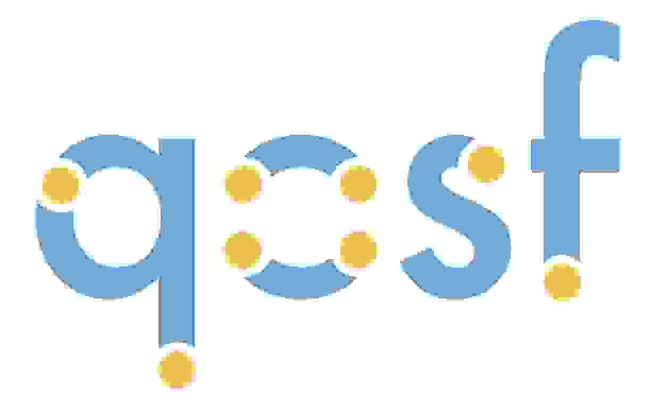

In [25]:
path = r"mentee\mentee.jpeg" # path to the image
temp = open(path, "rb")
mentee_image = temp.read()
temp.close()
mentee_image = bytearray(mentee_image) # converting to byte array for encryption
Image(filename=path) # displaying original image

Now that we have the initial image as a byte array, we can use its length to determine how many bits our key has to be.

In [16]:
n = len(mentee_image)
print(n)

17038


In the BB84 protocol, the sender will choose a random bit and random basis for a qubit that they want to send to the receiver. Usually, the sender is called Alice and the receiver is called Bob. Once Alice creates a qubit with state psi (|+>, |->, |0>, or |1>), she will use quantum teleportation to transport this state to Bob. Teleportation is achieved because Alice and Bob's qubits will be an entangled Bell pair. Then, Bob will measure his qubit in a random basis. Alice and Bob announce their bases publicly, and the measured bit will be kept if the bases are the same (different bases will lead to a 50% chance of getting the right bit measured).

First, we can make the encode_qubit() function. This function will create a state psi given the randomized bit and base that Alice selected. The function will return a circuit with the state psi on qubit 0 of that circuit.

In [17]:
def encode_qubit(bit, basis):
    qc = QuantumCircuit(3, 3)
    if basis == 0: # measuring in Z basis
        if bit == 0:
            pass # state |0> --> initial state, so no action needed
        else:
            qc.x(0) # state |1> --> X gate switches the amplitudes
    else: # measuring in X basis
        if bit == 0:
            qc.h(0) # state |+> --> H gate creates superposition of 0 and 1
        else:
            qc.x(0)
            qc.h(0) # state |-> --> X gate to switch amplitude then H gate for superposition
    qc.barrier()
    return qc

For example, here's what the quantum circuit would like initially if Alice sent the state |+>, which is 0 in the X basis

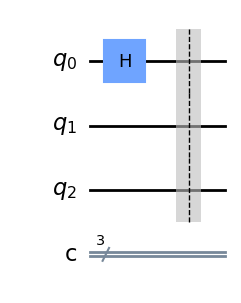

In [9]:
circuit = QuantumCircuit(3, 3)
circuit.h(0)
circuit.barrier()
circuit.draw(output='mpl')


Now, we can create a Bell pair between qubits 1 and 2 of the circuit. This will allow us to transfer the information from qubit 1 (Alice) to qubit 2 (Bob) via quantum teleportation.

In [18]:
def teleport_state(qc):
    qc.h(1)
    qc.cx(1, 2) # creating the entangled Bell pair between Alice and Bob
    qc.barrier()
    
    qc.cx(0, 1)
    qc.h(0) # Alice teleports state from qubit 0 (state psi) to qubit 1
    qc.barrier()
    
    qc.measure([0, 1], [0, 1]) # Alice measures both qubits, stores them in classical bits 0 and 1
    qc.barrier()
    return qc    

Here's what that would look like on the example circuit we started 2 cells above.

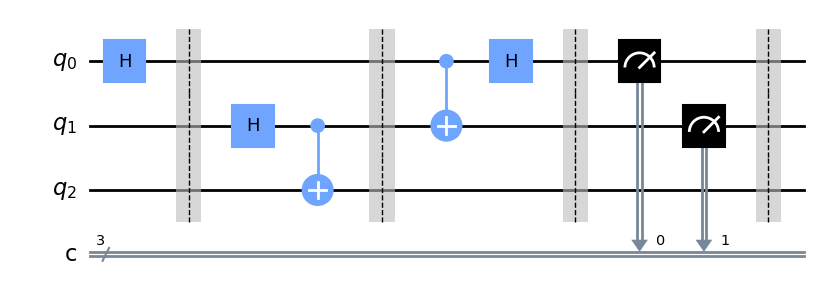

In [10]:
circuit.h(1)
circuit.cx(1, 2)
circuit.barrier()
circuit.cx(0, 1)
circuit.h(0)
circuit.barrier()
circuit.measure([0, 1], [0, 1])
circuit.barrier()
circuit.draw(output='mpl')

The first section of the circuit is our encoded state. Right now, it is a H gate applied to the state |0>, which means our initial state is |+>. Then, the second section is creating an entangled Bell pair between qubit 1 (Alice) and qubit 2 (Bob) using an H gate and a controlled X. Then, Alice transports the state psi from qubit 0 to her half of the bell pair (section 3), then measures qubit 0 and qubit 1 to collapse their states (section 4) so that Bob can do his actions.

The entangled Bell pair between Alice and Bob has been created. Alice also collapsed the state of qubits 0 and 1 by measuring them. Now, Bob must work with his half of the Bell pair to measure the bit value Alice is trying to send.

In [19]:
def measure_qubit(qc, base):
    qc.cx(1, 2)
    qc.cz(0, 2) # Bob completes the teleportation
    qc.barrier()
    
    if base == 1:
        qc.h(2) # adding H gate if measuring in X basis --> changing basis of measurement
        
    qc.measure([2], [2]) # measuring the qubit
    
    simulator = Aer.get_backend('aer_simulator')
    qobject = assemble(qc, shots=1, memory=True) # running circuit 1 time
    result = simulator.run(qobject).result()
    return int(str(result.get_memory()[0])[0]) # retrieving measurement of qubit 2 (Bob's qubit) from classical bit 2

Once again, let's take a look at the example circuit. We need to measure in the X-basis, so we add an H gate so our measurement will be in the X-basis.

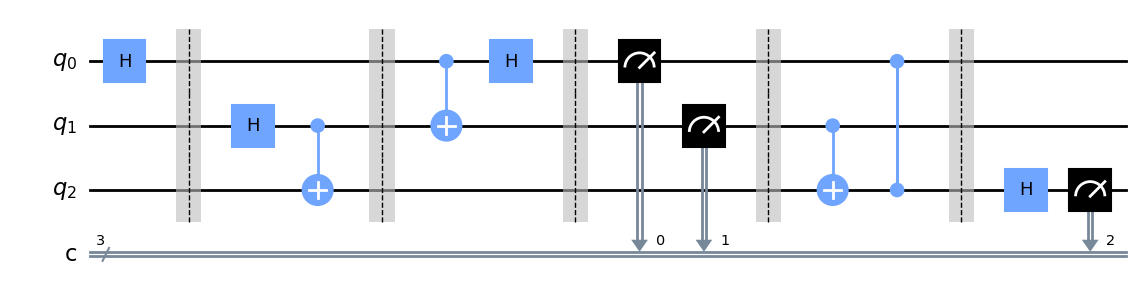

In [11]:
circuit.cx(1, 2)
circuit.cz(0, 2)
circuit.barrier()
circuit.h(2)
circuit.measure([2], [2])
circuit.draw(output='mpl')

Bob completes the teleporation with a controlled X and Z gate, then measures his qubit and stores it in classical bit 2. 

Now that the functions are defined, we can get to creating and sending a key between the mentee (Alice) and mentor (Bob).

In [20]:
key = [] # we will be appending to this list to get our key

while len(key) != n: # loop runs until key length = image "length"
    mentee_bit = randint(2) # mentee picks random bit
    mentee_base = randint(2) # mentor picks random base
    circuit = encode_qubit(mentee_bit, mentee_base) # encoding state psi --> random bit and base
    
    teleport_state(circuit) # creating Bell pair and teleporting state to mentor
    
    mentor_base = randint(2) # mentor picks random base
    mentor_bit = measure_qubit(circuit, mentor_base) # get bit value from measuring mentor half of Bell pair
    
    if mentee_base == mentor_base: # appending if mentee's base = mentor's base (announced publicly)
        key.append(mentor_bit) # bit would be "garbage" if bases were different: measured bit would be random

Now, we can use this key to create an encrypted version to exist in the public channel for the mentor to access.

In [26]:
encrypted_image = mentee_image # creating copy of mentee_image for encryption

q = 0
for index, values in enumerate(encrypted_image):
    encrypted_image[index] = values ^ key[q] # XOR image and key bits
    q += 1

public_image = open(r"public.jpeg", "wb") # creating public.jpeg
public_image.write(encrypted_image) # writing encrypted image to public.jpeg
public_image.close()

Image(filename=r"public.jpeg") # displaying encrypted image

As you can see, the encrypted image is not able to be rendered. Once it is decrypted, it will look like the original image.

Mentor can now access and decrypt the encrypted image using the key that was teleported to them.

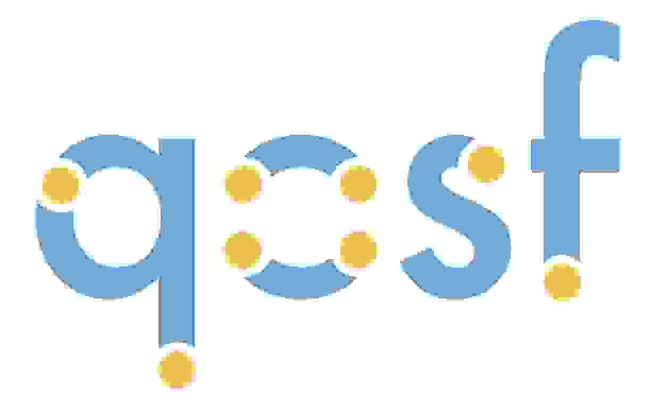

In [27]:
decrypted_image = encrypted_image # creating copy of encrypted_image for decryption

q = 0
for index, values in enumerate(decrypted_image): # decrypting with teleported key
    decrypted_image[index] = values ^ key[q] # XOR image and key bits
    q += 1

mentor_image = open(r"mentor\mentor.jpeg", "wb") # creating mentor.jpeg in mentor folder
mentor_image.write(decrypted_image) # writing decrypted image to mentor.jpeg
mentor_image.close()

Image(filename=r"mentor\mentor.jpeg") # displaying decrypted image

Done! The image was successfully sent from mentee to mentor via the BB84 protocol and quantum teleportation.